In [2]:
import pickle
import numpy as np
import glob
import pickle
import matplotlib
import matplotlib.backends.backend_tkagg
#from mmetro_v7 import Mmetro_Utils
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.stats as stats
import random
import matplotlib.animation as animation
import scipy as scipy

def hanning(M, *varargin):
    m = np.linspace(-(M-1)/2,(M-1)/2,M)  
    Win = 0.5 + 0.5*np.cos(2*np.pi*m/M)
    if len(varargin) > 0:
        N = varargin[0]
        Win = np.broadcast_to(Win,(N,M)).T
    return Win

In [3]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def get_RP(data, frame_size, N, freq_min, freq_max, nfft=2**8, fs=1e6, bg_sub=True):
    # reshape the data
    data = np.reshape(data, (N, frame_size), order='F')
    # background subtraction
    if bg_sub:
        data = data - data[:,0][:,None]

    # normalization
    for i in range(data.shape[1]):
        data[:,i] = data[:,i] - data[:,i].mean()

    # hanning window used for getting RP
    Win2D = hanning(N, int(frame_size))

    RP = signal.zoom_fft(np.multiply(data, Win2D), fn=[freq_min,freq_max], m=nfft, axis=0, fs=fs)
    return RP

def get_RD(RP, frame_size, nfft):
    WinVel2D = hanning(int(frame_size), nfft)
    WinVel2D = WinVel2D.transpose()

    # getting RD
    RPExt = RP
    RPExt = RPExt - np.mean(RPExt, axis=1)[:,np.newaxis]
    RD = np.fft.fft(np.multiply(RPExt, WinVel2D), n=nfft, axis=1)
    RD = np.fft.fftshift(RD, axes=(1,))
    RD[:,116:140] = 0 # removing middle doppler noise
    return RD
    
# not working
def angle_fft(RP_cube, nfft, d_over_lambda=0.5, window=np.hanning):
    """
    RD_cube : (R, D, N_rx)
    returns
        theta      : (Nfft_ang,) angle grid in radians
        P_ang_cube : (R, D, Nfft_ang) power spectrum
    """
    R, D, N_rx = RP_cube.shape
    w = window(N_rx)                            # spatial window                        # broadcast
    AoA = np.fft.fftshift(
            np.fft.fft(RP_cube * w, n=nfft, axis=2), axes=2)
    AoA_db = 20.0 * np.log10(np.abs(AoA) + 1e-12)
    AoA_norm = AoA_db - AoA_db.max()
    AoA_norm[AoA_norm < -25.0] = -25.0
    AoA_norm = AoA_norm.max(axis=1)
    # # P = np.abs(AoA) ** 2

    # u = (np.arange(nfft) - nfft/2) / nfft
    # theta = np.arcsin(u / d_over_lambda)        # radians
    # WinAnt2D = hanning(int(N_rx), nfft)
    # # sca_win_ant = WinAnt2D.sum()
    # WinAnt2D = WinAnt2D.transpose()
    # j_opt = np.fft.fftshift(np.fft.fft(RP_cube * WinAnt2D, n=nfft, axis=2) / sca_win_ant, axes=2)
    # j_db = 20.0 * np.log10(np.abs(j_opt) + 1e-12)
    # j_norm = j_db - j_db.max()
    # j_norm[j_norm < -25.0] = -25.0
    # j_norm = j_norm.max(axis=1)  # collapse chirp dimension
    return AoA_norm

# Template matching for sinc pattern in RD 
def generate_template(period, frame_size, f_tag, nfft=2**8, tag_duty_cycle=0.5):
    # period = Tc (chrip time)
    # frame size = Nc (#chirps in a frame)
    # nfft = 256 = Ns (number of samples, also the number of points in the FFT)

    # generating a time vector with values for each chirp (period)
    t = np.arange(0, period*frame_size, period)

    # generating a square wave during that time with the given duty cycle 
    sq_wav = signal.square(2*np.pi*f_tag*t, tag_duty_cycle)

    # the template is the FFT of the square wave
    sq_wav_fft = np.fft.fftshift(np.fft.fft(sq_wav, n=nfft, axis=0))
    return sq_wav_fft


def get_range(frame_idx, data_raw, antenna_pick, frame_size, N, chirp_slope, period, range_min, range_max, f_tag, fs=1e6, nfft=2**8):
    data_single_chn = data_raw[:,:,antenna_pick] # select one channel (antena)
    data_snapshot = data_single_chn[:,frame_idx] # select the frame

    # define frequency max and min
    freq_min = 2*range_min * chirp_slope / c
    freq_max = 2*range_max * chirp_slope / c
    
    # get the range profile 
    RP = get_RP(data=data_snapshot, \
                frame_size=frame_size, 
                N=N, 
                freq_min=freq_min, 
                freq_max=freq_max, 
                nfft=nfft,
                fs=fs,
                bg_sub=True)

    # get the range-doppler
    RD = get_RD(RP, frame_size=frame_size, nfft=nfft)

    # Template matching code
    # 400 is the number of frequency steps 
    csweep = np.zeros(400)
    corr_240 = 0
    corr_332 = 0
    for fstep in range(0,400):
        # generate the template for fstep'th frequency step 
        template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=fstep)

        # bunch of stuff happening here, but basically applying the template (currently (N,)) through the entire range axis and then taking dot product with the RD
        # template[:, np.newaxis]                                  --> changes shape from (N,) to (N,1)
        # np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1) --> copies the template in all the range bins 
        correlation = np.sum(np.abs(RD) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1)
        
        # stores the max value for that frequency 
        csweep[fstep] = np.max(correlation)
    
    # Trying to locate the tag -- get indexes for the tags
    # --- why 4 faces? Top face and face D share the same control signal 
    f_tags = [183, 337, 250, 127]
    max_idxs = np.zeros(4)
    for i in range(len(f_tags)):
        # generate the template for that particular tag face
        template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])
        correlation = np.sum(np.abs(RD) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

        # -- why are we calculating this in the loop? 
        freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
        range_steps = freq_steps * c / 2 / chirp_slope

        # get the range index of the highest correlation
        max_idxs[i] = np.argmax(correlation)
    return RP, RD, csweep, max_idxs, range_steps

# not working
def get_angle(frame_idx, data_raw, frame_size, N, chirp_slope, period, range_min, range_max, f_tag, fs=1e6, nfft=2**8):
    # data_snapshot = data_raw[:, frame_idx, :]      # (N, N_rx)
    # N_rx = data_snapshot.shape[1]
    # define frequency max and min
    freq_min = 2*range_min * chirp_slope / c
    freq_max = 2*range_max * chirp_slope / c
    # print(freq_min)
    # print(freq_max)
    v_range = np.arange(nfft) / nfft * fs * c / (2 * chirp_slope)
    r_max_idx = np.argmin(np.abs(v_range - range_max))
    v_range_ext = v_range[: r_max_idx + 1]
    r_offset = np.sum(v_range_ext < 0.1)

    RP = np.empty((nfft,nfft, 4), dtype=complex)
    RD = np.empty((nfft,nfft, 4), dtype=complex)
    for ant in range(4):
        data_single_chn = data_raw[:,:,ant] # select one channel (antena)
        data_snapshot = data_single_chn[:,frame_idx] # select the frame
        RPExt = get_RP(data=data_snapshot,
            frame_size=frame_size, 
            N=N, 
            freq_min=freq_min, 
            freq_max=freq_max, 
            nfft=nfft,
            fs=fs,
            bg_sub=True)
        
        RP[:,:,ant] = RPExt #- np.mean(RPExt, axis=1)[:,np.newaxis]
        # RPExt = RPExt - np.mean(RPExt, axis=1)[:,np.newaxis]
        # RP[:,:,ant] = RPExt[r_offset : r_max_idx + 2,:]
        # RD_temp = get_RD(RPExt, frame_size, nfft)
        # RD[:, :, ant] = RD_temp
    # RD = np.empty((RP.shape[0], nfft, 4), dtype=complex)

    AoA = angle_fft(RP, nfft=nfft)
    # freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    # range_steps = freq_steps * c / 2 / chirp_slope
    return AoA # theta_grid, P_ang, range_steps
        

    

## Microdisplacement helper functions 

In [ ]:
# what does this do? 
def get_period(Igrid, Fgrid):
    freqIndex = []
    for frameIdx in range(n_frames):
        Ipeaks, _ = signal.find_peaks((Igrid[:,frameIdx]))
        Fpeaks, _ = signal.find_peaks((Fgrid[:,frameIdx]))
        # print("peaks: " + str(Ipeaks))
        per1temp = np.diff(Ipeaks)
        per2temp = np.diff(Fpeaks)

        freqIndex.extend(per1temp)          # adds all elements of per1temp to freqIndex
        freqIndex.extend(per2temp)          # adds all elements of per2temp to freqIndex

    # Calculate period using a trimmed mean (similar to MATLAB's trimmean)
    if len(freqIndex) > 0:
        period = stats.trim_mean(freqIndex, 0.1)  # 10% trim on both ends (ignores extreme values)
    else:
        period = 0  # Handle case where no peaks are found
    return period                                 # just the mean of periods --> this should be okay 

# Unwrap phases and compute unwrapped distance
def unwrapPi(phases):
    # Custom phase unwrapping similar to MATLAB's unwrap with pi-periodicity
    return np.unwrap(phases, period=np.pi)

def get_displacement(Igrid, Qgrid):
    phi = np.linspace(0, np.pi, 4001)  # (0 : pi/4000 : pi) -> 4001 points from 0 to pi
    x = np.arange(0, dopwidth)  # x = 1 : size(magFFTAll, 2)
    triWave = np.tile(signal.windows.triang(dopwidth), (n_frames, 1))
    plt.plot(triWave[0])

    period = get_period(Igrid, Qgrid)
    print(period)

    # Preallocate autocorrelation arrays
    autoCorr2a = np.zeros((n_frames, len(phi)))
    autoCorr2b = np.zeros((n_frames, len(phi)))
    for phiIdx, phiVal in enumerate(phi):
        sinW = np.tile(np.abs(np.sin(x * np.pi / period + phiVal)), (n_frames, 1))                      # just repeats across frames
        print(sinW.shape)
        # if phiIdx == 0: 
        #     plt.plot(sinW[0, :])
        cosW = np.tile(np.abs(np.cos(x * np.pi / period + phiVal)), (n_frames, 1))

        # we are taking the sum along axis=1 (dopwidth dimension) to calculate the correlation
        autoCorr2a[:, phiIdx] = np.sum(normalize(Igrid.transpose()) * sinW * triWave, axis=1)           # correlating I with sin
        autoCorr2b[:, phiIdx] = np.sum(normalize(Qgrid.transpose()) * cosW * triWave, axis=1)           # correlating Q with cos -> why? 
    autocorr = autoCorr2a + autoCorr2b
    # print(autocorr)
    # Find the index of the maximum correlation
    I = np.argmax(autocorr, axis=1)

    # Extract phases
    angles = phi[I]

    lam = c/(24.125e9)
    # for distance in m
    # return (lam / (4 * np.pi)) * unwrapPi(angles) 
    return unwrapPi(angles)

## Processing

30.50862068965517
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(50, 80)
(

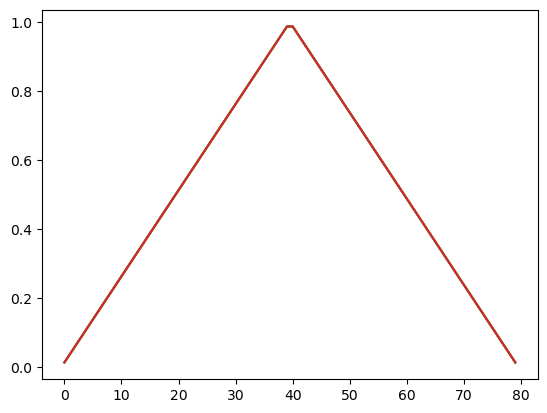

In [12]:
# %matplotlib ipympl
data_raw = pickle.load(open('/nas-data/soham/drone-landing/straight_100cm_H-24GHz.pickle', 'rb'))

antenna_pick = 2
nfft = 2**8
fs = 1e6
c = 2.98e8
range_min = 0
range_max = 5
f_tag = 500

cfg = data_raw['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']

data_signal_raw = data_raw['Data']
# n_frames = data_signal_raw.shape[1]
n_frames = 50

dopwidth = 80 #width of doppler
Igrid = np.zeros((4,dopwidth, n_frames))
Qgrid = np.zeros((4,dopwidth, n_frames))
Pgrid = np.zeros((4,dopwidth, n_frames))
dopgrid = np.zeros((nfft, n_frames))

max_idxs = np.zeros(n_frames)
max_idxs2 = np.zeros(n_frames)
max_idxs3 = np.zeros(n_frames)
max_idxs4 = np.zeros(n_frames)

for frame in range(0,n_frames):
    # Call get_range and return computed RP, RD, csweep
    RP, RD, csweep, max_idx, range_steps = get_range(
        frame_idx = frame+2,
        data_raw=data_signal_raw,
        antenna_pick=antenna_pick,
        frame_size=frame_size,
        N=N,
        chirp_slope=chirp_slope,
        period=period,
        range_min=range_min,
        range_max=range_max,
        f_tag=f_tag,
        fs=fs,
        nfft=nfft
    )

    # Finding the max_idx in the range FFT for each face (each frequency)
    max_idxs[frame] = range_steps[int(max_idx[0])]
    max_idxs2[frame] = range_steps[int(max_idx[1])]
    max_idxs3[frame] = range_steps[int(max_idx[2])]
    max_idxs4[frame] = range_steps[int(max_idx[3])]
    # max_idx[0],max_idx[1],max_idx[2] = 90,90,90
    # Clear previous frame

    # ax1.set_title("Range Doppler (0-5m); Frame " + str(frame))
    # ax1.set_ylabel("Range")
    # ax1.imshow(np.abs(RD), extent=[range_min, range_max, range_max, range_min])

    # searching for tag doppler bins
    # modbinsleft = np.argsort(np.abs(RD[int(max_idx[0]),0:120]))
    # modbinsright = np.argsort(np.abs(RD[int(max_idx[0]),140:])) + 140 
    # mbl1 = modbinsleft[-2]
    # mbl2 = modbinsleft[-1]
    # mbr1 = modbinsright[-2]
    # mbr2 = modbinsright[-1]
    # modbinleft= np.argmax(np.abs(RD[max_idx,0:120]))
    # modbinright= np.argmax(np.abs(RD[max_idx,140:])) + 140
    # print(modbinsleft)
    # print(modbinsright)

    # hardcode doppler bin selection
    #side 0: 127 Hz: 113, 143
    #side 1: 183 Hz: 106, 150
    #side 2: 250 Hz: 101, 155
    #side 3: 337 Hz: 90, 166
    side1 = 1
    side2 = 3
    side3 = 2
    side4 = 0
    
    modfreqs = [127, 183, 250, 337]
    modfreq1 = modfreqs[side1]
    modfreq2 = modfreqs[side2]
    modfreq3 = modfreqs[side3]
    modfreq4 = modfreqs[side4]

    binsleft = [113, 106, 101, 90]          # negative doppler frequency bins for tag face frequencies 
    binsright = [144, 150, 155,166]         # positive doppler frequency bins for tag face frequencies
    mbl = [0,0,0,0]
    mbr = [0,0,0,0]
    mbl[0] = binsleft[side1]
    mbr[0] = binsright[side1]
    mbl[1] = binsleft[side2]
    mbr[1] = binsright[side2]
    mbl[2] = binsleft[side3]
    mbr[2] = binsright[side3]
    mbl[3] = binsleft[side4]
    mbr[3] = binsright[side4]

    # int(max_idx[1])     : gives the detected range index, r_tag 
    # np.abs(RD)[ r_tag ] : stores the values for RD(r_tag, _) for all f_tag's 
    # RD =      [[ . . . . . . . . . . ],
    #            [ . . . . . . . . . . ],
    #            [ * * * * * * * * * * ],  --- r_tag
    #            [ . . . . . . . . . . ],
    #            [ . . . . . . . . . . ]]
    # dop_grid= [[*           ],
    #            [*           ],
    #            [     ...    ],
    #            [*           ]]
    dopgrid[:,frame] = np.abs(RD)[int(max_idx[1])]    # dopgrid : N_fft (256) x N_frames 


    for i in range(4):
        # (int(max_idx[1])-int(dopwidth/2)):(int(max_idx[1])+int(dopwidth/2))  : This is probably taking the range subset 
        # mbl[i] : max bin left of the i_th frequency 
        rdbinleft = RD[(int(max_idx[1])-int(dopwidth/2)):(int(max_idx[1])+int(dopwidth/2)), mbl[i]]         # RD_bin_left
        rdbinright = RD[(int(max_idx[1])-int(dopwidth/2)):(int(max_idx[1])+int(dopwidth/2)), mbr[i]]        # RD_bin_right
        I_tag = (rdbinright + np.conjugate(rdbinleft))/2
        Q_tag = (rdbinright - np.conjugate(rdbinleft))*1j/2

        # phase is also across the range subset 
        phase = np.atan(I_tag/Q_tag) 

        Igrid[i][:,frame] = normalize(np.abs((I_tag)))
        Qgrid[i][:,frame] = normalize(np.abs((Q_tag)))
        Pgrid[i][:,frame] = normalize(np.abs(phase))


# Now instead of looking at the shift of IQ domain range subset across time, I have to look at it across antennas for the current frame 

unwrappedDist = get_displacement(Igrid[0], Qgrid[0])
unwrappedDist2 = get_displacement(Igrid[1], Qgrid[1])
unwrappedDist3 = get_displacement(Igrid[2], Qgrid[2])
unwrappedDist4 = get_displacement(Igrid[3], Qgrid[3])

## Plotting

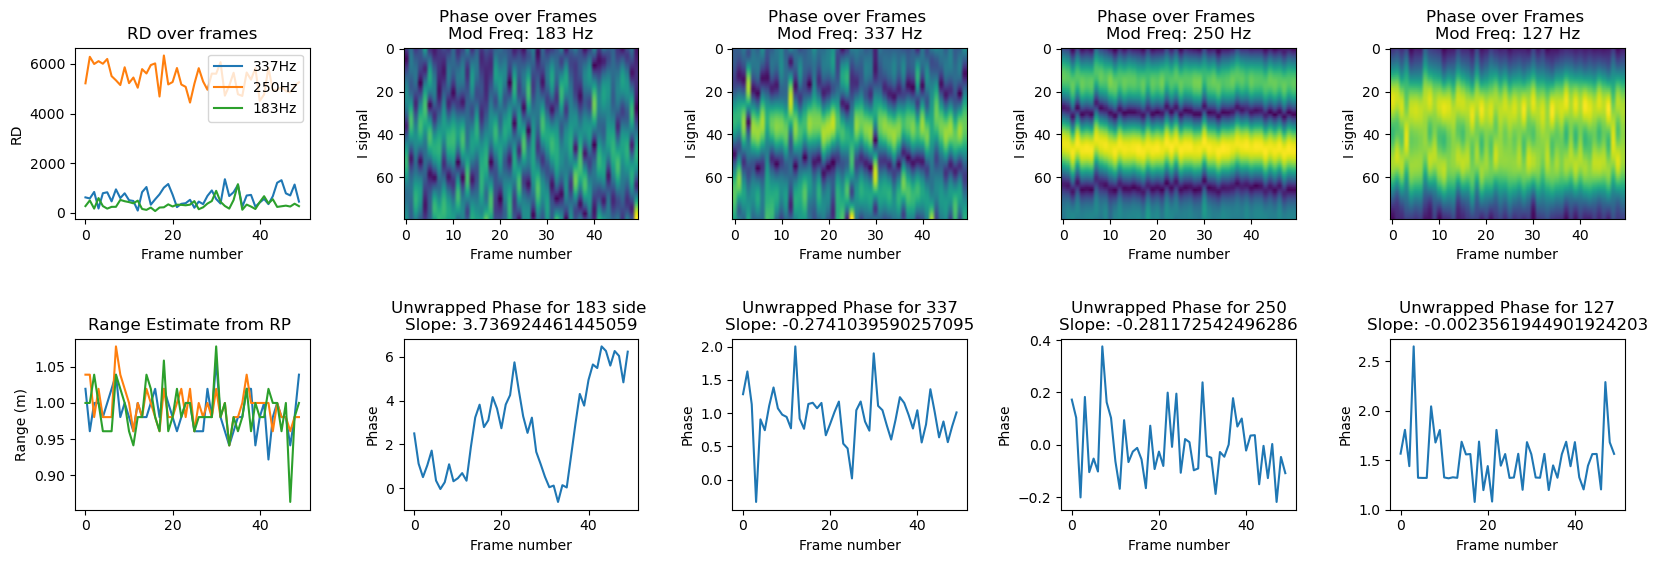

In [8]:
# Initialize plot

fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(20, 6))
plt.subplots_adjust(hspace= 0.7, wspace = 0.4)

ax1.set_title("RD over frames")
ax1.set_xlabel("Frame number")
# ax1.set_ylim(75, 175)
ax1.set_ylabel("RD")
dopgrid2 = dopgrid
# dopgrid2[88:92] = 0
# dopgrid2[164:169] = 0
# dopgrid2[0:70] = 0

# ax1.imshow(dopgrid2[90:160], aspect='auto')
ax1.plot(dopgrid2[90])
ax1.plot(dopgrid2[101])
ax1.plot(dopgrid2[106])
ax1.legend(["337Hz", "250Hz", "183Hz"], loc = "upper right")

ax2.set_title("Phase over Frames \nMod Freq: " + str(modfreq1) + " Hz")
ax2.set_xlabel("Frame number")
ax2.set_ylabel("I signal")
ax2.imshow(Igrid[0], aspect='auto')

ax3.set_title("Phase over Frames \nMod Freq: " + str(modfreq2) + " Hz")
ax3.set_xlabel("Frame number")
ax3.set_ylabel("I signal")
ax3.imshow(Igrid[1], aspect='auto')

ax4.set_title("Phase over Frames \nMod Freq: " + str(modfreq3) + " Hz")
ax4.set_xlabel("Frame number")
ax4.set_ylabel("I signal")
ax4.imshow(Igrid[2], aspect='auto')

ax5.set_title("Phase over Frames \nMod Freq: " + str(modfreq4) + " Hz")
ax5.set_xlabel("Frame number")
ax5.set_ylabel("I signal")
ax5.imshow(Igrid[3], aspect='auto')

ax7.set_title("Unwrapped Phase for "+str(modfreq1) +" side " + "\nSlope: " + str(unwrappedDist[n_frames-1]-unwrappedDist[0]))
ax7.set_ylabel("Phase")
ax7.set_xlabel("Frame number")
# ax6.set_ylim(0, 0.025)
ax7.plot(unwrappedDist)


ax8.set_title("Unwrapped Phase for "+str(modfreq2) + "\nSlope: " + str(unwrappedDist2[n_frames-1]-unwrappedDist2[0]))
ax8.set_ylabel("Phase")
ax8.set_xlabel("Frame number")
# ax6.set_ylim(0, 0.025)
ax8.plot(unwrappedDist2)

ax9.set_title("Unwrapped Phase for "+str(modfreq3) + "\nSlope: " + str(unwrappedDist3[n_frames-1]-unwrappedDist3[0]))
ax9.set_ylabel("Phase")
ax9.set_xlabel("Frame number")
# ax6.set_ylim(0, 0.025)
ax9.plot(unwrappedDist3)

ax10.set_title("Unwrapped Phase for "+str(modfreq4) + "\nSlope: " + str(unwrappedDist4[n_frames-1]-unwrappedDist4[0]))
ax10.set_ylabel("Phase")
ax10.set_xlabel("Frame number")
# ax6.set_ylim(0, 0.025)
ax10.plot(unwrappedDist4)

# print("Displacement 250hz:" + str(unwrappedDist))
# print("Displacement 337hz:" + str(unwrappedDist2))
slope1 = unwrappedDist[n_frames-1]-unwrappedDist[0]
slope2 = unwrappedDist2[n_frames-1]-unwrappedDist2[0]
slope3 = unwrappedDist3[n_frames-1]-unwrappedDist3[0]
slope4 = unwrappedDist4[n_frames-1]-unwrappedDist4[0]

# print("Range average 183Hz: "+ str(np.mean(max_idxs)))
# print("Range average 337Hz: "+ str(np.mean(max_idxs2)))
# print("Range average 240Hz: "+ str(np.mean(max_idxs3)))
# print("Diff in slope: "+str(slope3-slope2))
# ax4.set_title("Difference between two displacements " + "\nDiff: " +str(slope2-slope1))
# ax4.plot(unwrappedDist - unwrappedDist2)

ax6.set_title("Range Estimate from RP ")
ax6.set_ylabel("Range (m)")
ax6.plot(max_idxs)
ax6.plot(max_idxs2)
ax6.plot(max_idxs3)

#phase increase, when closer, decrease when farther
phase_diff1 = (unwrappedDist2)- unwrappedDist3
phase_diff2 = (unwrappedDist2)- (unwrappedDist)

# ax6.set_title("phase difference between\n 337Hz side and the other sides")
# ax6.plot(phase_diff1)
# ax6.plot(phase_diff2)
# ax6.legend(["250Hz", "183Hz"], loc = "upper right")
plt.show()